Loading COCO annotations...
loading annotations into memory...
Done (t=18.61s)
creating index...
index created!
Filtering dataset...
Filtered dataset saved to /kaggle/working/filtered_coco.csv
Loading filtered data and splitting dataset...
Record count per category_id:
category_id
1     1000
17    1000
18    1000
Name: count, dtype: int64

Training dataset saved to /kaggle/working/train_data.csv
Testing dataset saved to /kaggle/working/test_data.csv
Initializing ViT processor...
Loading and preprocessing training data...
Loading and preprocessing test data...
Initializing ViT model...


config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/352M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFViTForImageClassification: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing TFViTForImageClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFViTForImageClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFViTForImageClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Starting model training...
Epoch 1/30
75/75 [==============================] - ETA: 0s - loss: 0.6754 - accuracy: 0.7475
Epoch 1 completed
Training accuracy: 0.7475
Validation accuracy: 0.8000
75/75 [==============================] - 58s 379ms/step - loss: 0.6754 - accuracy: 0.7475 - val_loss: 0.5020 - val_accuracy: 0.8000 - lr: 1.0000e-04
Epoch 2/30
75/75 [==============================] - ETA: 0s - loss: 0.3418 - accuracy: 0.8838
Epoch 2 completed
Training accuracy: 0.8838
Validation accuracy: 0.8067
75/75 [==============================] - 24s 323ms/step - loss: 0.3418 - accuracy: 0.8838 - val_loss: 0.5024 - val_accuracy: 0.8067 - lr: 1.0000e-04
Epoch 3/30
75/75 [==============================] - ETA: 0s - loss: 0.1586 - accuracy: 0.9554
Epoch 3 completed
Training accuracy: 0.9554
Validation accuracy: 0.8217
75/75 [==============================] - 25s 330ms/step - loss: 0.1586 - accuracy: 0.9554 - val_loss: 0.4913 - val_accuracy: 0.8217 - lr: 1.0000e-04
Epoch 4/30
75/75 [=========

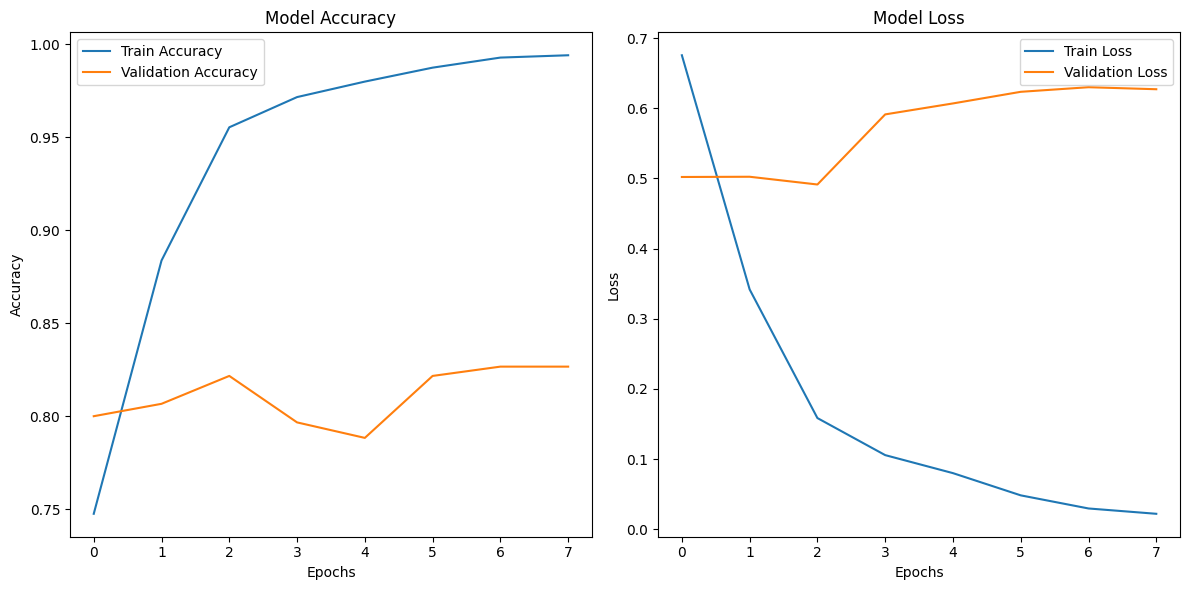


Generating predictions and plotting ROC curve...
19/19 [==============================] - 5s 114ms/step


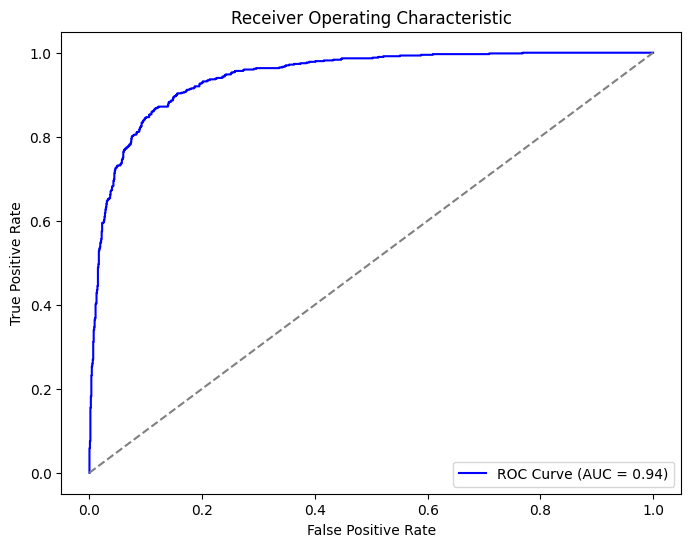


Calculating precision-recall curves and mAP...
Mean Average Precision (mAP): 0.8852


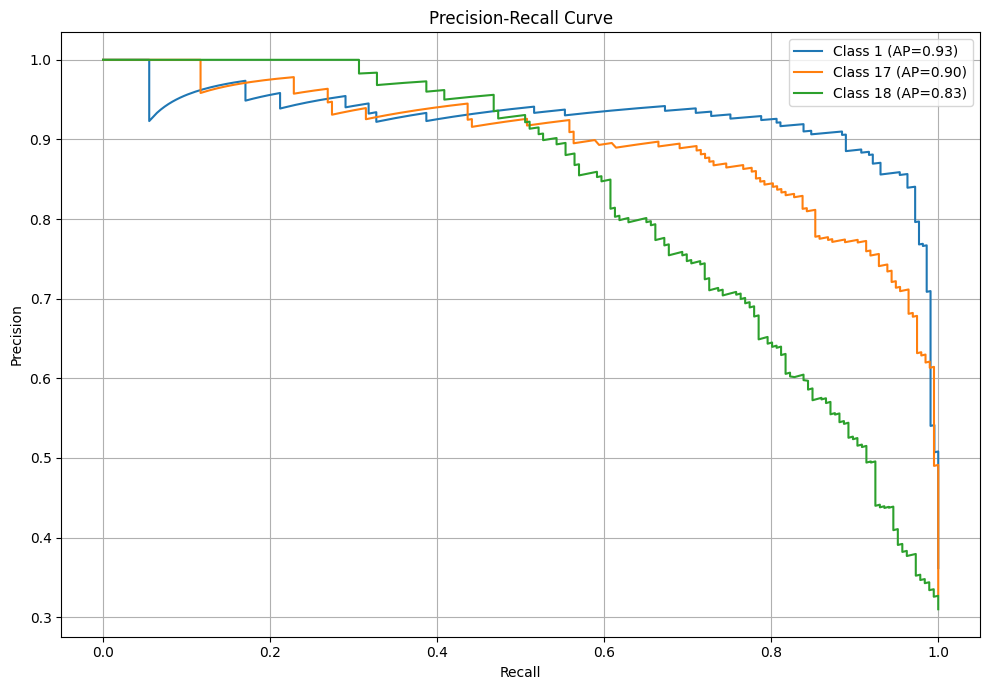


Training and evaluation complete!


In [2]:
#Imports
import os
import pandas as pd
import random
from pycocotools.coco import COCO
from sklearn.model_selection import train_test_split
import tensorflow as tf
from transformers import TFViTForImageClassification, ViTImageProcessor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
import cv2
import numpy as np
from datetime import datetime
import torch
import warnings
import logging

# Filter out specific warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)
tf.get_logger().setLevel(logging.ERROR)

# Suppress TensorFlow deprecation warnings
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Paths
TRAIN_PATH = '/kaggle/input/coco-2017-dataset/coco2017/train2017'
VAL_PATH = '/kaggle/input/coco-2017-dataset/coco2017/val2017'
ANNOTATIONS_PATH = '/kaggle/input/coco-2017-dataset/coco2017/annotations'
FILTERED_DATASET = '/kaggle/input/filtered-coco-dataset'
WORKING_DIR = '/kaggle/working'
FILTERED_CATEGORIES = ['person', 'cat', 'dog']

# Load COCO annotations
print("Loading COCO annotations...")
annotations_file = os.path.join(ANNOTATIONS_PATH, 'instances_train2017.json')
coco = COCO(annotations_file)

# Get category IDs for the selected categories
category_ids = coco.getCatIds(catNms=FILTERED_CATEGORIES)

# Generate filtered dataset
print("Filtering dataset...")
filtered_data = []
for category_id in category_ids:
    ann_ids = coco.getAnnIds(catIds=[category_id])
    anns = coco.loadAnns(ann_ids)
    selected_anns = random.sample(anns, min(1000, len(anns)))
    for ann in selected_anns:
        image_info = coco.loadImgs(ann['image_id'])[0]
        filtered_data.append({
            "image_id": ann['image_id'],
            "image": image_info['file_name'],
            "category_id": ann['category_id']
        })

# Save filtered data to CSV
filtered_csv_path = os.path.join(WORKING_DIR, 'filtered_coco.csv')
filtered_df = pd.DataFrame(filtered_data)
filtered_df.to_csv(filtered_csv_path, index=False)

print(f"Filtered dataset saved to {os.path.abspath(filtered_csv_path)}")

# Load the filtered CSV and split the dataset
print("Loading filtered data and splitting dataset...")
data = pd.read_csv(filtered_csv_path)

# Display record count per category_id
category_counts = data['category_id'].value_counts()
print("Record count per category_id:")
print(category_counts)
print("")

# Split into training and testing datasets
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

# Save the split datasets
train_csv_path = os.path.join(WORKING_DIR, 'train_data.csv')
test_csv_path = os.path.join(WORKING_DIR, 'test_data.csv')

train_data.to_csv(train_csv_path, index=False)
test_data.to_csv(test_csv_path, index=False)

print(f"Training dataset saved to {os.path.abspath(train_csv_path)}")
print(f"Testing dataset saved to {os.path.abspath(test_csv_path)}")

def initialize_vit_model(num_classes, learning_rate=1e-4):
    """Initialize and compile ViT model with proper configuration."""
    model = TFViTForImageClassification.from_pretrained(
        'google/vit-base-patch32-224-in21k',
        num_labels=num_classes,
        ignore_mismatched_sizes=True,
        from_pt=True
    )
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
    
    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=['accuracy']
    )
    
    return model

# Initialize the ViT processor
print("Initializing ViT processor...")
processor = ViTImageProcessor.from_pretrained(
    'google/vit-base-patch32-224-in21k',
    do_resize=True,
    size={"height": 224, "width": 224},
    do_normalize=True
)

def preprocess_image(image_path):
    """Load and preprocess an image for ViT with error handling."""
    try:
        image = cv2.imread(image_path)
        if image is None:
            raise ValueError(f"Failed to load image: {image_path}")
        
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        processed = processor(images=image, return_tensors="tf")
        return processed['pixel_values'][0]
    except Exception as e:
        print(f"Error processing image {image_path}: {str(e)}")
        return None

def load_data(data, path_prefix):
    """Load and preprocess images with error handling."""
    images = []
    labels = []
    for _, row in data.iterrows():
        image_path = os.path.join(path_prefix, row['image'])
        processed_image = preprocess_image(image_path)
        if processed_image is not None:
            images.append(processed_image)
            labels.append(row['category_id'])
    return np.array(images), np.array(labels)

# Load and preprocess the data
print("Loading and preprocessing training data...")
X_train, y_train = load_data(train_data, TRAIN_PATH)
print("Loading and preprocessing test data...")
X_test, y_test = load_data(test_data, TRAIN_PATH)

# Encode labels
label_encoder = LabelEncoder()
y_train_encoded = tf.keras.utils.to_categorical(label_encoder.fit_transform(y_train))
y_test_encoded = tf.keras.utils.to_categorical(label_encoder.transform(y_test))

# Initialize model
print("Initializing ViT model...")
model = initialize_vit_model(num_classes=len(FILTERED_CATEGORIES))

# Custom training callback
class TrainingCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        print(f"\nEpoch {epoch + 1} completed")
        if logs:
            print(f"Training accuracy: {logs.get('accuracy', 0):.4f}")
            print(f"Validation accuracy: {logs.get('val_accuracy', 0):.4f}")

# Training callbacks
callbacks = [
    TrainingCallback(),
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=3,
        min_lr=1e-6
    )
]

# Train the model
print("\nStarting model training...")
history = model.fit(
    {"pixel_values": X_train}, y_train_encoded,
    validation_data=({"pixel_values": X_test}, y_test_encoded),
    epochs=30,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)

# Get current datetime
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')

# Save the trained model
model_path = os.path.join(WORKING_DIR, f'vit_coco_{timestamp}.h5')
model.save_pretrained(model_path)
print(f"\nTrained model saved at {model_path}")

# Plot and save training metrics
print("\nGenerating and saving plots...")
accuracy_loss_plot_path = os.path.join(WORKING_DIR, f'accuracy_loss_plot_{timestamp}.png')
roc_curve_plot_path = os.path.join(WORKING_DIR, f'roc_curve_plot_{timestamp}.png')
pr_curve_path = os.path.join(WORKING_DIR, f'pr_curve_{timestamp}.png')

# Plot training metrics
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.savefig(accuracy_loss_plot_path, dpi=300)
plt.show()

# Generate predictions and plot ROC curve
print("\nGenerating predictions and plotting ROC curve...")
y_pred = model.predict({"pixel_values": X_test})['logits']
y_pred = tf.nn.softmax(y_pred, axis=1).numpy()

fpr, tpr, _ = roc_curve(y_test_encoded.ravel(), y_pred.ravel())
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.title('Receiver Operating Characteristic')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.savefig(roc_curve_plot_path, dpi=300)
plt.show()

# Calculate and plot precision-recall curves
print("\nCalculating precision-recall curves and mAP...")
num_classes = y_test_encoded.shape[1]
average_precisions = {}

plt.figure(figsize=(10, 7))
for i in range(num_classes):
    precision, recall, _ = precision_recall_curve(y_test_encoded[:, i], y_pred[:, i])
    ap = average_precision_score(y_test_encoded[:, i], y_pred[:, i])
    average_precisions[i] = ap
    plt.plot(recall, precision, label=f"Class {label_encoder.classes_[i]} (AP={ap:.2f})")

mAP = np.mean(list(average_precisions.values()))
print(f"Mean Average Precision (mAP): {mAP:.4f}")

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()
plt.savefig(pr_curve_path)
plt.show()

print("\nTraining and evaluation complete!")